<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2 - Ames Housing Data and Kaggle Challenge

# Contents (Part 1) 

- Executive Summary
- Problem Statement
- Background and Research
- Data Cleaning
- Exploratory Data Analysis

# Contents (Part 2) - This notebook 

- [Feature Engineering](#Feature-Engineering)
- [Data Dictionary](#Data-Dictionary)
- [Modelling](#Modelling)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

# Contents (Part 3)

- Data Cleaning
- Feature Engineering

## Importing necessary libraries

The libraries below will be used in this notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn import metrics

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Overrides Matplotlib theme with Seaborn's 
sns.set(font_scale = 1.2)
sns.set_context('talk')

# Enables Pandas to display all the columns
pd.set_option('display.max_columns', None)

# Enables Pandas to display all the rows
pd.set_option('display.max_rows', None)

# Ignore convergence warnings after model testing complete
import warnings
warnings.filterwarnings('ignore')

## Loading the data 

The following cleaned dataset will be loaded:

In [2]:
train = pd.read_csv('../data/train_cleaned.csv')

In [3]:
train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,72.0,13517,Pave,1.0,Lvl,3.0,CulDSac,2.0,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,3.0,2.0,CBlock,3.0,3.0,1.0,6.0,533.0,1.0,0.0,192.0,725.0,GasA,4.0,Y,4.0,725,754,0,1479,0.0,0.0,2,1,3,1,3.0,6,7.0,0,0.0,Attchd,1976.0,2.0,2.0,475.0,3.0,3.0,2.0,0,44,0,0,0,0,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,1.0,Lvl,3.0,CulDSac,2.0,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,3.0,2.0,PConc,4.0,3.0,1.0,6.0,637.0,1.0,0.0,276.0,913.0,GasA,4.0,Y,4.0,913,1209,0,2122,1.0,0.0,2,1,4,1,3.0,8,7.0,1,3.0,Attchd,1997.0,2.0,2.0,559.0,3.0,3.0,2.0,0,74,0,0,0,0,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,0.0,Lvl,3.0,Inside,2.0,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,2.0,3.0,CBlock,3.0,3.0,1.0,6.0,731.0,1.0,0.0,326.0,1057.0,GasA,2.0,Y,4.0,1057,0,0,1057,1.0,0.0,1,0,3,1,3.0,5,7.0,0,0.0,Detchd,1953.0,1.0,1.0,246.0,3.0,3.0,2.0,0,52,0,0,0,0,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,0.0,Lvl,3.0,Inside,2.0,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,2.0,2.0,PConc,4.0,3.0,1.0,1.0,0.0,1.0,0.0,384.0,384.0,GasA,3.0,Y,4.0,744,700,0,1444,0.0,0.0,2,1,3,1,2.0,7,7.0,0,0.0,BuiltIn,2007.0,3.0,2.0,400.0,3.0,3.0,2.0,100,0,0,0,0,0,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,1.0,Lvl,3.0,Inside,2.0,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,2.0,2.0,PConc,2.0,4.0,1.0,1.0,0.0,1.0,0.0,676.0,676.0,GasA,2.0,Y,4.0,831,614,0,1445,0.0,0.0,2,0,3,1,2.0,6,7.0,0,0.0,Detchd,1957.0,1.0,2.0,484.0,3.0,3.0,0.0,0,59,0,0,0,0,0,3,2010,WD,138500


# Feature Engineering 

## Deriving new columns out of existing ones

Some new columns can be made from existing columns that may better represent the features for the model. 

The only features that represent age in the data are in date form, which would have to be subtracted from one another. Hence, we subtracted the year the house was built, from the year the house was sold. 

In [4]:
train['house_age'] = train['yr_sold'] - train['year_built']

We will make a new column for the garage age, in a similar method as what was done for the house age. This will help address the issue with using a year '0' to represent that no garage was built. Due to this issue, the original `garage_yr_blt` column will also be dropped. 

In [5]:
# Get the difference in values for those rows where the 'garage_yr_blt' is not 0
train['garage_age'] = train['yr_sold'] - train['garage_yr_blt'][train['garage_yr_blt'] != 0]

# The newly created columns has NaNs that will be filled with 0.0
train['garage_age'] = train['garage_age'].fillna(0)

# Drop the 'garage_yr_blt' column
train.drop(columns='garage_yr_blt', inplace=True)

We can also make a column for the number of years till any remodeling or addition was done. 

Just to check if there are any zero values for `year_remod/add`:

In [6]:
train[train['year_remod/add'] == 0]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice,house_age,garage_age


There are none. We can proceed. The new column is created as follows:

In [7]:
train['age_at_remod'] = train['yr_sold'] - train['year_remod/add']

There is no feature that captures the total number of baths in the property. Hence, a new column is created as follows::

In [8]:
train['total_baths'] = train['full_bath'] + train['half_bath'] + train['bsmt_full_bath'] + train['bsmt_half_bath']

The garage quality may interact with its car capacity and an interaction term for these two features may better capture a relationship with sale price. Hence, a new column is created as follows:

In [9]:
train['garage_overall'] = train['garage_qual'] * train['garage_cars']

These are the engineered columns (including garage age from the data cleaning portion).

In [10]:
train.loc[:,'house_age':].head()

,house_age,garage_age,age_at_remod,total_baths,garage_overall
0,34,34.0,5,3.0,6.0
1,13,12.0,12,4.0,6.0
2,57,57.0,3,2.0,3.0
3,4,3.0,3,3.0,6.0
4,110,53.0,17,2.0,6.0


The summary statistics appear reasonable.

In [11]:
train.loc[:,'house_age':].describe()

,house_age,garage_age,age_at_remod,total_baths,garage_overall
count,2044.000000,2044.000000,2044.000000,2044.000000,2044.000000
mean,36.142368,27.639432,23.657534,2.436888,5.290117
std,30.188424,25.152003,21.020050,0.940953,2.345047
min,0.000000,0.000000,0.000000,1.000000,0.000000
25%,7.000000,5.000000,4.000000,2.000000,3.000000
50%,34.000000,23.000000,15.000000,2.000000,6.000000
75%,54.000000,46.000000,43.000000,3.000000,6.000000
max,136.000000,114.000000,60.000000,8.000000,15.000000


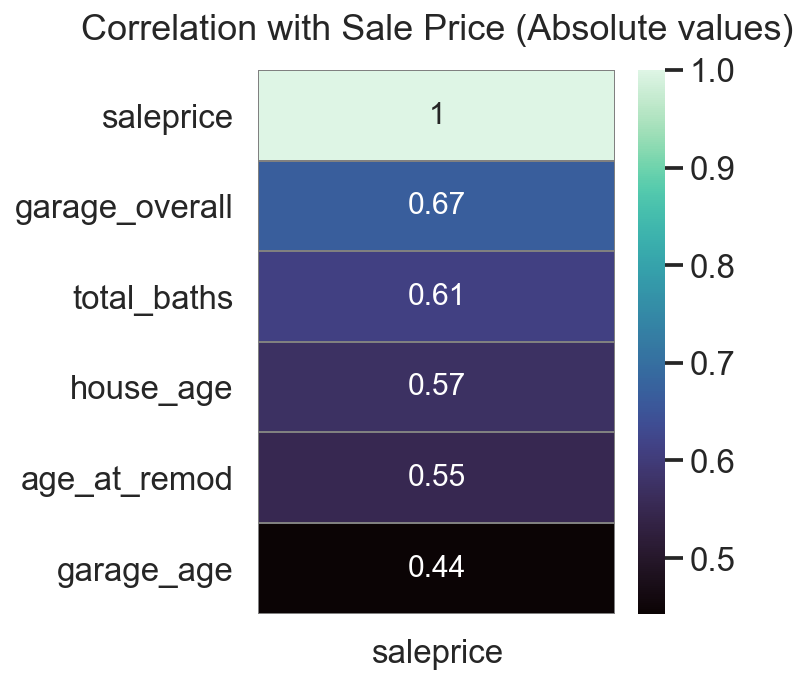

In [12]:
# Limits the subsequent correlation calculation to only the engineered columns
df_feat_eng = train.loc[:,'saleprice':]

plt.figure(figsize=(4,5))
sns.heatmap(df_feat_eng.corr()[['saleprice']].abs().sort_values(by='saleprice', ascending=False),
            annot=True,
            annot_kws={'size': 15},
            linewidths=1,
            linecolor='grey',
            cmap='mako').set_title('Correlation with Sale Price (Absolute values)',
                                                          fontsize=18,
                                                          pad=15);

The `garage_cars` feature had a correlation of r=0.65 with sale price. The `garage_qual` feature had a correlation of r=0.29 with sale price. The resulting feature had a correlation of r=0.67, a slight improvement. Ideally, this metric is a better measure of overall garage quality.

The `total_baths` feature was engineered from `full_bath`, `half_bath`, `bsmt_full_bath`, `bsmt_half_bath`. Their respective correlations with sale price were 0.53, 0.28, 0.28, and -0.04. The resulting correlation of `total_baths` with sale price was 0.61, an improvement.

`year_built` had the same correlation with sale price as`house_age`, except now with a negative sign, and `age_at_remod` had the same correlation with sale price as `year_remod/add`, with a negative sign as well. However, the data is now more intepretable as an age which can be compared between houses immediately, instead of a year which has to be referenced with another year. This will helpful for any insights obtained subsequently. 

`garage_age` had a similar correlation to the other ages with sale price, and with a negative sign as well. However, the correlation with sale price is not as high as some other garage-related features. Given that a garage simply being old may not be as strong a predictor as its quality, a more ideal way would be to use other more representative features to capture the influence of having a garage, such as the engineered `garage_overall` feature. 

## Dealing with extreme outliers 

There was a house with very high above ground living area, which was an extreme outlier. It turns out that the sale price for that house is actually not high. 

In [13]:
train[train['gr_liv_area'] > 5000]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice,house_age,garage_age,age_at_remod,total_baths,garage_overall
960,1499,908154235,60,RL,313.0,63887,Pave,3.0,Bnk,3.0,Corner,2.0,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,4.0,2.0,PConc,5.0,3.0,4.0,6.0,5644.0,1.0,0.0,466.0,6110.0,GasA,4.0,Y,4.0,4692,950,0,5642,2.0,0.0,2,1,3,1,4.0,12,7.0,3,4.0,Attchd,3.0,2.0,1418.0,3.0,3.0,2.0,214,292,0,0,0,480,0,1,2008,New,160000,0,0.0,0,5.0,6.0


The correlation of above ground living area with sale price is as follows:

In [14]:
train[['saleprice']].corrwith(train['gr_liv_area'])

saleprice    0.706092
dtype: float64

As this outlier seems to be too extreme as seen from the scatter plot previously, that entry will be removed:

In [15]:
train.drop(train[train['gr_liv_area'] > 5000].index, inplace=True)

Checking again, there is a slight improvement in the correlation. 

In [16]:
train[['saleprice']].corrwith(train['gr_liv_area'])

saleprice    0.719694
dtype: float64

No other outliers were removed. Even if we do see skewing in some of the features, removing too many outliers could affect the ability of the model to generalise to unseen data, if outliers will be present in unseen data as well. Hence, only the most extreme outlier was removed.

## Dropping numerical columns with low correlation with `saleprice` 

In order for a linear regression model to work best, the features should have a linear relationship with the target. To ensure this, it is a straightforward approach to try removing the features with low correlation with sale price. 

To do this, we can retrieve a list of absolute correlation values, i.e., we are interested in whether or not there is a high correlation, but not if it is positive or negative. This is because a negative relationship that is still linear is still helpful to the model.

The list is as follows:

In [17]:
saleprice_abs_corr = train.corr()['saleprice'].abs()

In [18]:
saleprice_abs_corr.sort_values(ascending=False)

saleprice          1.000000
overall_qual       0.803599
gr_liv_area        0.719694
exter_qual         0.714820
kitchen_qual       0.694339
garage_overall     0.667549
total_bsmt_sf      0.666429
garage_area        0.655061
garage_cars        0.648383
1st_flr_sf         0.648273
bsmt_qual          0.613196
total_baths        0.612154
house_age          0.572028
year_built         0.571976
garage_finish      0.559615
age_at_remod       0.551938
year_remod/add     0.550534
fireplace_qu       0.539093
full_bath          0.538476
mas_vnr_area       0.511387
totrms_abvgrd      0.509762
fireplaces         0.473624
heating_qc         0.458258
bsmtfin_sf_1       0.447208
garage_age         0.443456
bsmt_exposure      0.428599
bsmtfin_type_1     0.352254
open_porch_sf      0.339218
lot_frontage       0.337785
wood_deck_sf       0.329020
lot_area           0.303501
lot_shape          0.296253
paved_drive        0.290352
garage_qual        0.285461
bsmt_full_bath     0.284934
half_bath          0

To do this, we want to keep the features with stronger correlations (anything above 0.5). The question is where to set the threshold, as dropping too many features may affect the model performance. 

Based on some experimentation with the linear models on their default settings, dropping the columns with correlations lesser than 0.45 showed the best performance. 

The list of columns to be dropped according to the threshold is generated as such:

In [19]:
to_drop = list(saleprice_abs_corr[saleprice_abs_corr < 0.45].index)

This list has 39 columns:

In [20]:
len(to_drop)

39

The following columns will be dropped. We can see that some of the columns we have done work on will ultimately be removed, such as `lot_frontage` and `garage_age`.

In [21]:
to_drop

['id',
 'pid',
 'ms_subclass',
 'lot_frontage',
 'lot_area',
 'lot_shape',
 'utilities',
 'land_slope',
 'overall_cond',
 'exter_cond',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_sf_1',
 'bsmtfin_type_2',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'electrical',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'half_bath',
 'bedroom_abvgr',
 'kitchen_abvgr',
 'functional',
 'garage_qual',
 'garage_cond',
 'paved_drive',
 'wood_deck_sf',
 'open_porch_sf',
 'enclosed_porch',
 '3ssn_porch',
 'screen_porch',
 'pool_area',
 'misc_val',
 'mo_sold',
 'yr_sold',
 'garage_age']

Dropping the columns:

In [22]:
train = train.drop(columns=to_drop)

42 columns are left:

In [23]:
len(train.columns)

42

Some of the columns removed were identifier columns such as ID and Parcel ID. The Lot frontage and Garage age features that we saw during the previous steps were removed  as well. Other features that were removed were basement and porch related features. 

## Checking for multicollinearity in the numerical features 

For linear regression, we would ideally remove features that have a strong correlation between each other. This phenomenon is known as multicollinearity. 

When there were correlated pairs with an absolute correlation value of more than 0.75, one of the columns was removed. The column removed was the one with a lower correlation with the sale price. 

In [24]:
# Generate a correlation matrix (absolute values)
train_feat_corr = train.corr().abs()

# Drop the row and column for 'saleprice' as we only want to study the features
train_feat_corr.drop(labels='saleprice', axis=0, inplace=True)
train_feat_corr.drop(labels='saleprice', axis=1, inplace=True)

# Create a mask for the upper triange
upper_tri_mask = np.triu(np.ones_like(train_feat_corr, dtype=bool))

# Get the masked correlation matrix
train_feat_corr = train_feat_corr.mask(upper_tri_mask)

# Reshape the correlation matrix into a stacked format
corr_list = train_feat_corr.stack().sort_values(ascending=False)

# Convert the stacked data into a DataFrame
corr_list = pd.DataFrame(corr_list).reset_index()

# Name the columns of the created DataFrame
corr_list.columns = 'feature_1', 'feature_2', '1_2_abs_corr'

# Get only the pairwise correlations that meet the specified condition
corr_list = corr_list[corr_list['1_2_abs_corr'] > 0.75]

In [25]:
# Generate the correlation of the features in the list to the target variable
for row in corr_list.index:
    corr_list.loc[row, '1_y_corr'] = train.corr().abs()['saleprice'][corr_list.loc[row, 'feature_1']]
    corr_list.loc[row, '2_y_corr'] = train.corr().abs()['saleprice'][corr_list.loc[row, 'feature_2']]    

In [26]:
corr_list

,feature_1,feature_2,1_2_abs_corr,1_y_corr,2_y_corr
0,house_age,year_built,0.999054,0.572028,0.571976
1,age_at_remod,year_remod/add,0.998053,0.551938,0.550534
2,garage_overall,garage_cars,0.986520,0.667549,0.648383
3,garage_area,garage_cars,0.896963,0.655061,0.648383
4,garage_overall,garage_area,0.896036,0.667549,0.655061
5,fireplace_qu,fireplaces,0.860692,0.539093,0.473624
6,totrms_abvgrd,gr_liv_area,0.812626,0.509762,0.719694
7,1st_flr_sf,total_bsmt_sf,0.792071,0.648273,0.666429


This is a filtered DataFrame of pairs of columns exceeding the threshold. The first 2 columns in this DataFrame represent the pairs of columns. The third column shows their (absolute value) correlation with each other. The final two columns show their respective (absolute value) correlations with sale price, to aid in selecting which one to drop. 

In [27]:
# Choose the columns to drop based on logical selection. 
# We only need to drop one, and so we drop the one with less correlation to sale price.

train.drop(columns=['year_built',
                    'year_remod/add',
                    'garage_cars',
                    'garage_area',
                    'fireplaces',
                    'totrms_abvgrd',
                    '1st_flr_sf'], inplace=True)

The year-related and garage-related features were correlated with the engineered columns resulting from feature engineering. The engineered columns were retained. Other features removed were fireplaces, total rooms above ground and the 1st floor square feet. 

## Converting categorical (nominal) datatypes to numerical format for modelling 

When the linear regression models were run with the default parameters, the three categorical features shown below were found to have the lowest impact on the model. It was found that removing these three columns improved the model performance. 

This could be because the filtering that was done previously was only for the numerical data, and also the ordinal data that had been converted to numerical format. 

Therefore, we did not include these 3 columns for our final modelling.

In [28]:
train.drop(columns=['exterior_2nd', 'condition_2', 'ms_zoning'], inplace=True)

The DataFrame is saved to a .csv for reference before encoding. This will be the DataFrame described in the Data Dictionary in the next section.

In [29]:
train.to_csv('../data/train_reference.csv', index=False)

Dummy encoding is then conducted on the DataFrame.

In [30]:
train = pd.get_dummies(train, drop_first=False)

In [31]:
train.head()

,overall_qual,mas_vnr_area,exter_qual,bsmt_qual,total_bsmt_sf,heating_qc,gr_liv_area,full_bath,kitchen_qual,fireplace_qu,garage_finish,saleprice,house_age,age_at_remod,total_baths,garage_overall,street_Grvl,street_Pave,land_contour_Bnk,land_contour_HLS,land_contour_Low,land_contour_Lvl,lot_config_Corner,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,neighborhood_Blmngtn,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_GrnHill,neighborhood_IDOTRR,neighborhood_Landmrk,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition_1_Artery,condition_1_Feedr,condition_1_Norm,condition_1_PosA,condition_1_PosN,condition_1_RRAe,condition_1_RRAn,condition_1_RRNe,condition_1_RRNn,bldg_type_1Fam,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,house_style_1.5Fin,house_style_1.5Unf,house_style_1Story,house_style_2.5Fin,house_style_2.5Unf,house_style_2Story,house_style_SFoyer,house_style_SLvl,roof_style_Flat,roof_style_Gable,roof_style_Gambrel,roof_style_Hip,roof_style_Mansard,roof_style_Shed,roof_matl_CompShg,roof_matl_Membran,roof_matl_Tar&Grv,roof_matl_WdShake,roof_matl_WdShngl,exterior_1st_AsbShng,exterior_1st_AsphShn,exterior_1st_BrkComm,exterior_1st_BrkFace,exterior_1st_CBlock,exterior_1st_CemntBd,exterior_1st_HdBoard,exterior_1st_ImStucc,exterior_1st_MetalSd,exterior_1st_Plywood,exterior_1st_Stone,exterior_1st_Stucco,exterior_1st_VinylSd,exterior_1st_Wd Sdng,exterior_1st_WdShing,mas_vnr_type_BrkCmn,mas_vnr_type_BrkFace,mas_vnr_type_None,mas_vnr_type_Stone,foundation_BrkTil,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,heating_GasA,heating_GasW,heating_Grav,heating_OthW,heating_Wall,central_air_N,central_air_Y,garage_type_2Types,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_type_NoGarage,sale_type_COD,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD
0,6,289.0,3.0,3.0,725.0,4.0,1479,2,3.0,0.0,2.0,130500,34,5,3.0,6.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,7,132.0,3.0,4.0,913.0,4.0,2122,2,3.0,3.0,2.0,220000,13,12,4.0,6.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,5,0.0,2.0,3.0,1057.0,2.0,1057,1,3.0,0.0,1.0,109000,57,3,2.0,3.0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,5,0.0,2.0,4.0,384.0,3.0,1444,2,2.0,0.0,3.0,174000,4,3,3.0,6.0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,6,0.0,2.0,2.0,676.0,2.0,1445,2,2.0,0.0,1.0,138500,110,17,2.0,6.0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2043 entries, 0 to 2043
Columns: 136 entries, overall_qual to sale_type_WD 
dtypes: float64(10), int64(6), uint8(120)
memory usage: 510.8 KB


The datatypes are now all numerical.

In [33]:
train.shape

(2043, 136)

136 columns are in the final DataFrame used for the modelling.

In [34]:
train.to_csv('../data/train_cleaned_engineered.csv', index=False)

The DataFrame is exported to a .csv for the process of the Kaggle submission.

# Data Dictionary

The Data Dictionary is documented here ([*source*](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)) and is as follows:

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**street**|object|train_reference|Type of road access to property.|
|**land_contour**|object|train_reference|Flatness of the property.|
|**lot_config**|object|train_reference|Lot configuration.|
|**neighborhood**|object|train_reference|Physical locations within Ames city limits.|
|**condition_1**|object|train_reference|Proximity to various conditions.|
|**bldg_type**|object|train_reference|Type of dwelling.|
|**house_style**|object|train_reference|Style of dwelling.|
|**overall_qual**|int64|train_reference|Rates the overall material and finish of the house.|
|**roof_style**|object|train_reference|Type of roof.|
|**roof_matl**|object|train_reference|Roof material.|
|**exterior_1st**|object|train_reference|Exterior covering on house.|
|**mas_vnr_type**|object|train_reference|Masonry veneer type.|
|**mas_vnr_area**|float64|train_reference|Masonry veneer area in square feet.|
|**exter_qual**|float64|train_reference|Evaluates the quality of the material on the exterior.|
|**foundation**|object|train_reference|Type of foundation.|
|**bsmt_qual**|float64|train_reference|Evaluates the height of the basement.|
|**total_bsmt_sf**|float64|train_reference|Total square feet of basement area.|
|**heating**|object|train_reference|Type of heating.|
|**heating_qc**|float64|train_reference|Heating quality and condition.|
|**central_air**|object|train_reference|Central air conditioning.|
|**gr_liv_area**|int64|train_reference|Above grade (ground) living area in square feet.|
|**full_bath**|int64|train_reference|Full bathrooms above grade.|
|**kitchen_qual**|float64|train_reference|Kitchen quality.|
|**fireplace_qu**|float64|train_reference|Fireplace quality.|
|**garage_type**|object|train_reference|Garage location.|
|**garage_finish**|float64|train_reference|Interior finish of the garage.|
|**sale_type**|object|train_reference|Type of sale.|
|**saleprice**|int64|train_reference|Sale price in dollars.|
|**house_age**|int64|train_reference|Age of the house in years.|
|**age_at_remod**|int64|train_reference|Age at which the house was remodelled, in years.|
|**total_baths**|float64|train_reference|Total number of baths in the property.|
|**garage_overall**|float64|train_reference|Interaction feature from the garage quality and the garage car capacity.|

# Modelling 

Several linear regression models will be tested, along with their cross-validated versions. Functions will be built for each of them so that the results can be called together for each regression model. 

## Dummy Regressor

The Dummy Regressor's strategy has to be specified when using it. For this case, we will use the mean. This results in a model where the regressor will always predict the mean of the supplied dataset. The function created for the Dummy Regressor is as follows:

In [35]:
def dr_defaults(df):
    
    # Splitting the dataset into X and y
    X = df.drop('saleprice', axis=1)
    y = df['saleprice'].values
    
    # Doing a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    # Instantiating the model
    dummy_regr = DummyRegressor(strategy="mean")
    dummy_regr.fit(X_train, y_train)

    # Making predictions
    y_preds_train = dummy_regr.predict(X_train)
    y_preds_test = dummy_regr.predict(X_test)
    
    # R-squred scores
    r2_train = metrics.r2_score(y_train, y_preds_train)
    r2_test = metrics.r2_score(y_test, y_preds_test)
    
    # Cross-validated R-squred scores
    r2_cv_train = cross_val_score(dummy_regr, X_train, y_train, cv=5).mean()
    
    # RMSE scores
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_preds_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_preds_test))

    print('Dummy Regression Training R-Squared:', r2_train)
    print('Dummy Regression Testing R-Squared:', r2_test)
    print('Dummy Regression Cross-Validated Train Split R-Squared:', r2_cv_train)
    print('\nDummy Regression Training RMSE:', rmse_train)
    print('Dummy Regression Testing RMSE:', rmse_test)

## Linear Regressor

The linear regressor is the linear regression model without any regularisation applied. It is good when there is a clear linear relationship between the features and the target which is not overly complex. The function created for the linear regressor is as follows:

In [36]:
def lr_defaults(df):
    
    # Splitting the dataset into X and y
    X = df.drop('saleprice', axis=1)
    y = df['saleprice'].values
    
    # Doing a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

    # Instantiating the model
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # Making predictions
    y_preds_train = lr.predict(X_train)
    y_preds_test = lr.predict(X_test)
    
    # R-squred scores
    r2_train = metrics.r2_score(y_train, y_preds_train)
    r2_test = metrics.r2_score(y_test, y_preds_test)
    
    # Cross-validated R-squred scores
    r2_cv_train = cross_val_score(lr, X_train, y_train, cv=5).mean()
    
    # RMSE scores
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_preds_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_preds_test))

    print('Linear Regression Training R-Squared:', r2_train)
    print('Linear Regression Testing R-Squared:', r2_test)
    print('Linear Regression Cross-Validated Train Split R-Squared:', r2_cv_train)
    print('\nLinear Regression Training RMSE:', rmse_train)
    print('Linear Regression Testing RMSE:', rmse_test)

## Lasso Regressor

The Lasso regressor is the linear regression model with Lasso regularisation applied. This model applies L1 regularisation, which applies a penalty based on the sum of the absolute values of the coefficients. This can aggresively reduce the size of coefficients to zero. This is advantageous in eliminating noisy or unnecessary features, but there may be a chance that this may reduce the signals too much. Because regularisation is involved, the Standard Scaler will be used. The function created for the Lasso regressor is as follows:

In [37]:
def lasso_defaults(df):
    
    # Splitting the dataset into X and y
    X = df.drop('saleprice', axis=1)
    y = df['saleprice'].values

    # Doing a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    # Using the Standard Scaler
    ss = StandardScaler()
    ss.fit(X_train)
    X_train = ss.transform(X_train)
    X_test = ss.transform(X_test)
    
    # Instantiating the model
    lasso = Lasso()
    lasso.fit(X_train, y_train)
    
    # Making predictions
    y_preds_train = lasso.predict(X_train)
    y_preds_test = lasso.predict(X_test)
    
    # R-squred scores
    r2_train = metrics.r2_score(y_train, y_preds_train)
    r2_test = metrics.r2_score(y_test, y_preds_test)
    
    # RMSE scores
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_preds_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_preds_test))
    
    # Instantiating the model    
    lassoCV = LassoCV()
    lassoCV.fit(X_train, y_train)
    
    # Making predictions
    y_preds_CV_train = lassoCV.predict(X_train)
    
    # Cross-validated R-squred scores
    r2_CV_train = metrics.r2_score(y_train, y_preds_CV_train)
    
    # Cross-validated RMSE scores
    rmse_CV_train = np.sqrt(metrics.mean_squared_error(y_train, y_preds_CV_train))

    print('Lasso Regression Training R-Squared:', r2_train)
    print('Lasso Regression Testing R-Squared:', r2_test)
    print('Lasso Regression Cross-Validated Train Split R-Squared:', r2_CV_train)
    print('\nLasso Regression Training RMSE:', rmse_train)
    print('Lasso Regression Testing RMSE:', rmse_test)
    print('Lasso Regression Cross-Validated Training RMSE:', rmse_CV_train)

## Ridge Regressor

The Ridge regressor is the linear regression model with Ridge regularisation applied. This model applies L2 regularisation, which applies a penalty based on the sum of the squared values of the coefficients. This is less aggressive than the Lasso model in reducing the size of coefficients to zero. This means that it could be an alternative to the Lasso model if the Lasso is problematic in that aspect. Because regularisation is involved, the Standard Scaler will be used. The function created for the Ridge regressor is as follows:

In [38]:
def ridge_defaults(df):
    
    # Splitting the dataset into X and y
    X = df.drop('saleprice', axis=1)
    y = df['saleprice'].values

    # Doing a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    # Using the Standard Scaler
    ss = StandardScaler()
    ss.fit(X_train)
    X_train = ss.transform(X_train)
    X_test = ss.transform(X_test)
    
    # Instantiating the model
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    
    # Making predictions
    y_preds_train = ridge.predict(X_train)
    y_preds_test = ridge.predict(X_test)
    
    # R-squred scores
    r2_train = metrics.r2_score(y_train, y_preds_train)
    r2_test = metrics.r2_score(y_test, y_preds_test)
 
    # RMSE scores
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_preds_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_preds_test))
    
    # Instantiating the model    
    ridgeCV = RidgeCV()
    ridgeCV.fit(X_train, y_train)
    
    # Making predictions
    y_preds_CV_train = ridgeCV.predict(X_train)
    
    # Cross-validated R-squred scores
    r2_CV_train = metrics.r2_score(y_train, y_preds_CV_train)
    
    # Cross-validated RMSE scores
    rmse_CV_train = np.sqrt(metrics.mean_squared_error(y_train, y_preds_CV_train))

    print('Ridge Regression Training R-Squared:', r2_train)
    print('Ridge Regression Testing R-Squared:', r2_test)
    print('Ridge Regression Cross-Validated Train Split R-Squared:', r2_CV_train)
    print('\nRidge Regression Training RMSE:', rmse_train)
    print('Ridge Regression Testing RMSE:', rmse_test)
    print('Ridge Regression Cross-Validated Training RMSE:', rmse_CV_train)

## Model results and analysis

### Dummy Regressor

In [39]:
dr_defaults(train)

Dummy Regression Training R-Squared: 0.0
Dummy Regression Testing R-Squared: -0.006646117366176707
Dummy Regression Cross-Validated Train Split R-Squared: -0.009134333200995081

Dummy Regression Training RMSE: 80894.04552821773
Dummy Regression Testing RMSE: 74506.79271958028


### Linear Regressor

In [40]:
lr_defaults(train)

Linear Regression Training R-Squared: 0.9070963481487242
Linear Regression Testing R-Squared: 0.8957110961825665
Linear Regression Cross-Validated Train Split R-Squared: 0.8772175679160652

Linear Regression Training RMSE: 24656.586269657375
Linear Regression Testing RMSE: 23981.50909734423


### Lasso Regressor

In [41]:
lasso_defaults(train)

Lasso Regression Training R-Squared: 0.9070963191707726
Lasso Regression Testing R-Squared: 0.8957438116734483
Lasso Regression Cross-Validated Train Split R-Squared: 0.903982655994184

Lasso Regression Training RMSE: 24656.59011502456
Lasso Regression Testing RMSE: 23977.74729549902
Lasso Regression Cross-Validated Training RMSE: 25066.367313553306


### Ridge Regressor

In [42]:
ridge_defaults(train)

Ridge Regression Training R-Squared: 0.9070960575389158
Ridge Regression Testing R-Squared: 0.8958106356540144
Ridge Regression Cross-Validated Train Split R-Squared: 0.907069493937284

Ridge Regression Training RMSE: 24656.62483348164
Ridge Regression Testing RMSE: 23970.06168288556
Ridge Regression Cross-Validated Training RMSE: 24660.14955983311


There is a great improvement from the baseline model (Dummy Regressor). The baseline R-squared score is always zero, as it simply predicts one value no matter the value of the features. Hence, it does not explain any of the variability seen in the target. The baseline RMSE showed that the Dummy Regressor is generally off-target by \\$74,506 in predicting the sale price. 

Between Linear, Lasso and Ridge regression, the results of the calculated metrics are very close. This may be because of the thorough feature engineering which resulted in the removal of a great deal of columns. Lasso and Ridge would have effectively removed features due to the regularisation penalty. This might mean that the remaining features already contribute to the model in a way that does not require extensive optimisation through regularisation. 

The models are performing similarly between the train and test data sets with a relatively small difference in the scores. Hence, we can conclude that the models are not overfitting to the training data, and they can generalise well to test data.

The cross-validated results are close to the test results which means that the test split is representative. Based on both the R-squared and RMSE values, the Ridge model has the highest R-squared values and lowest RMSE values in general. Hence, the Ridge CV model will be selected. The model's R-Squared score of 0.907 shows a high ability to explain the variability in the sale price with the given input features. The model's RMSE shows that the model would be estimated to be off-target by \\$24,660, a difference of \\$49,846.

## Checking assumptions for linear regression 

Linear regression relies on the following set of assumptions:

* L - Linear relationship between features and target
* I - Independent errors
* N - Normally distributed errors
* E - Equal variance of errors (homoscedasticity)
* M - No Multicollinearity/Independence of Predictors

Regarding the linear relationship and no multicollinearity, we have already ensured that during feature engineering. For the other assumptions, we will need to create some plots. First, we set up an instance of RidgeCV and get the predictions:

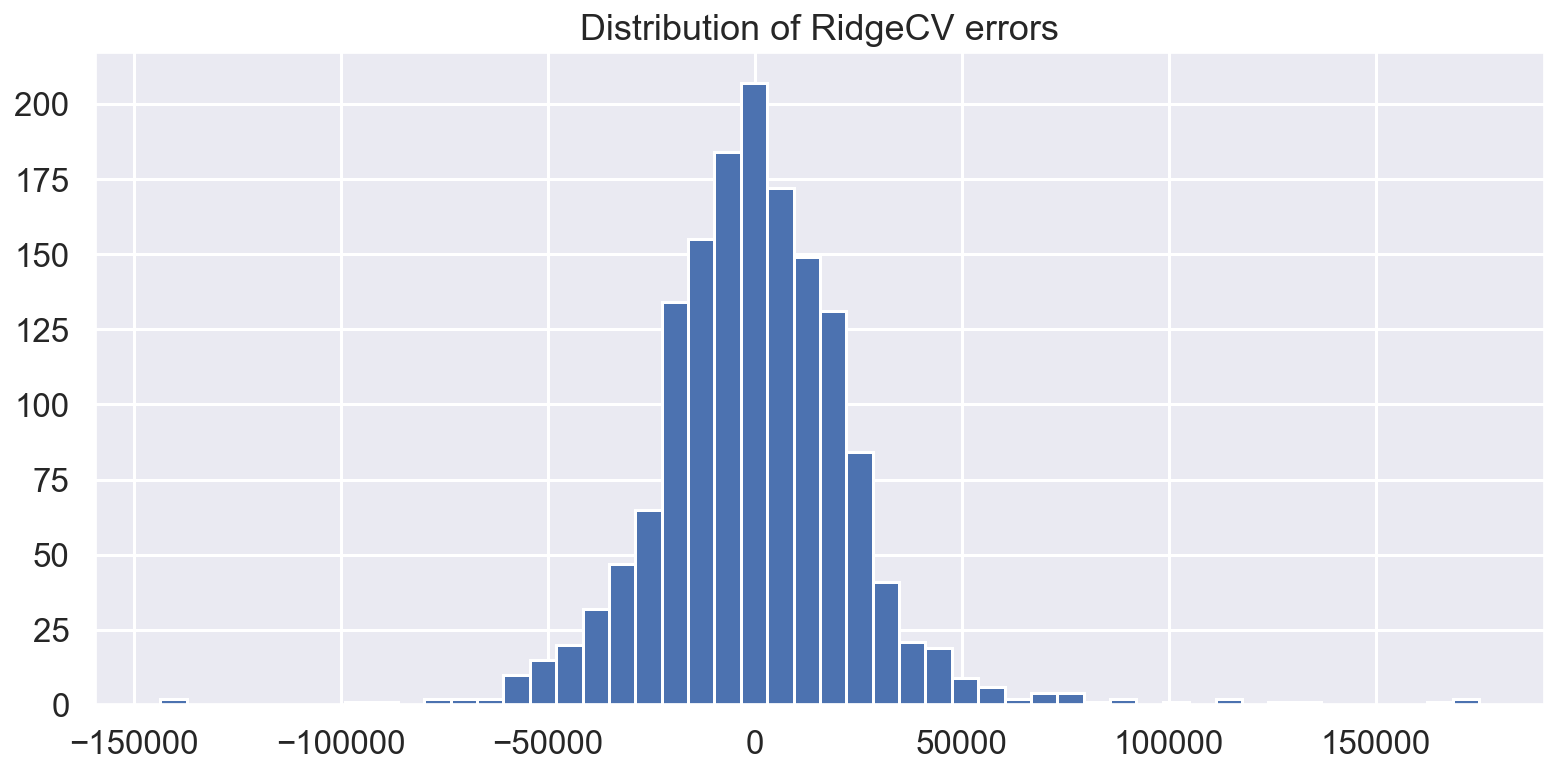

In [43]:
X = train.drop('saleprice', axis=1)
y = train['saleprice'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Making a copy before scaling for further plotting
X_train_unscaled = X_train.copy()

# Using the Standard Scaler
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

# Instantiating the model 
ridge = RidgeCV()
ridge.fit(X_train, y_train)

# Getting the predictions
y_preds_train = ridge.predict(X_train)

# Getting the errors
resids = y_train - y_preds_train

# Plotting the errors
plt.figure(figsize=(13,6))
plt.hist(resids, bins=50)
plt.title('Distribution of RidgeCV errors');

The errors are normally distributed. This fulfills the condition for normally distributed errors.

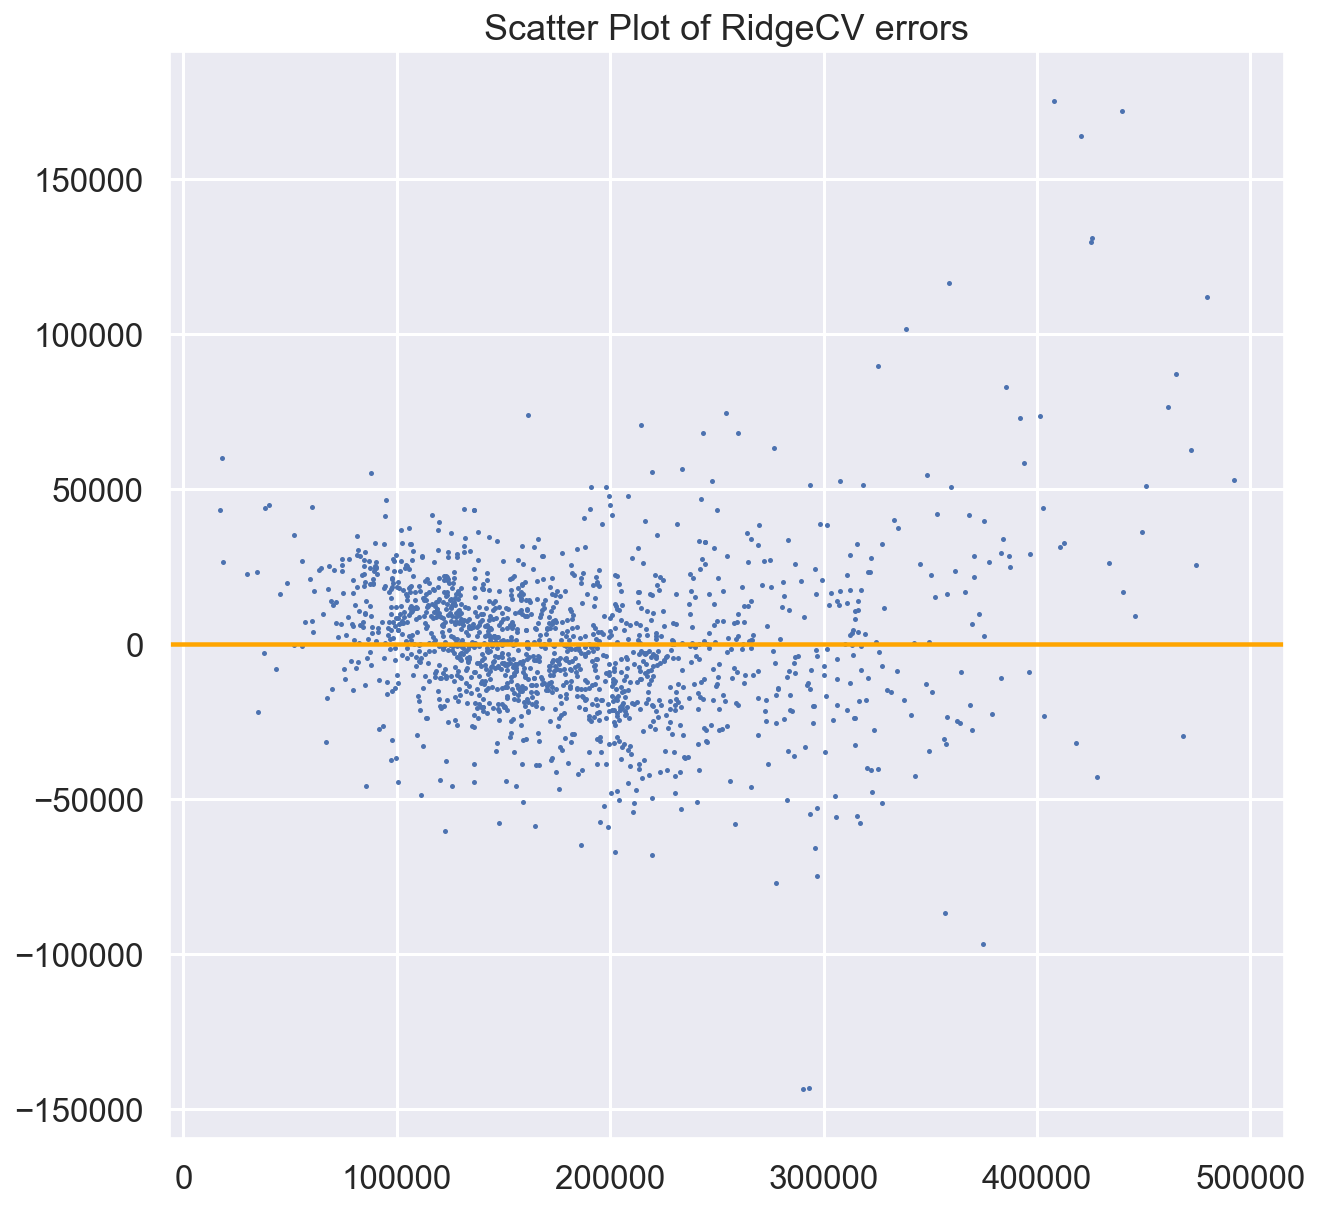

In [44]:
plt.figure(figsize=(10,10))
plt.scatter(y_preds_train, resids, s=1)
plt.axhline(0, color="orange")
plt.title('Scatter Plot of RidgeCV errors');

The values could be said to be independent as the scatter pattern is rather unstructured, but as the x-value increases, we see that the distance of the dots from the orange line starts to increase. This actually indicates heteroscedasticity. This could be due to the fact that only one outlier was removed, yet many variables were still skewed. Hence, the model does not fit the condition of homoscedascity.

## Visualising the predictions

A scatter plot can be created to visualise the accuracy of the predictions.

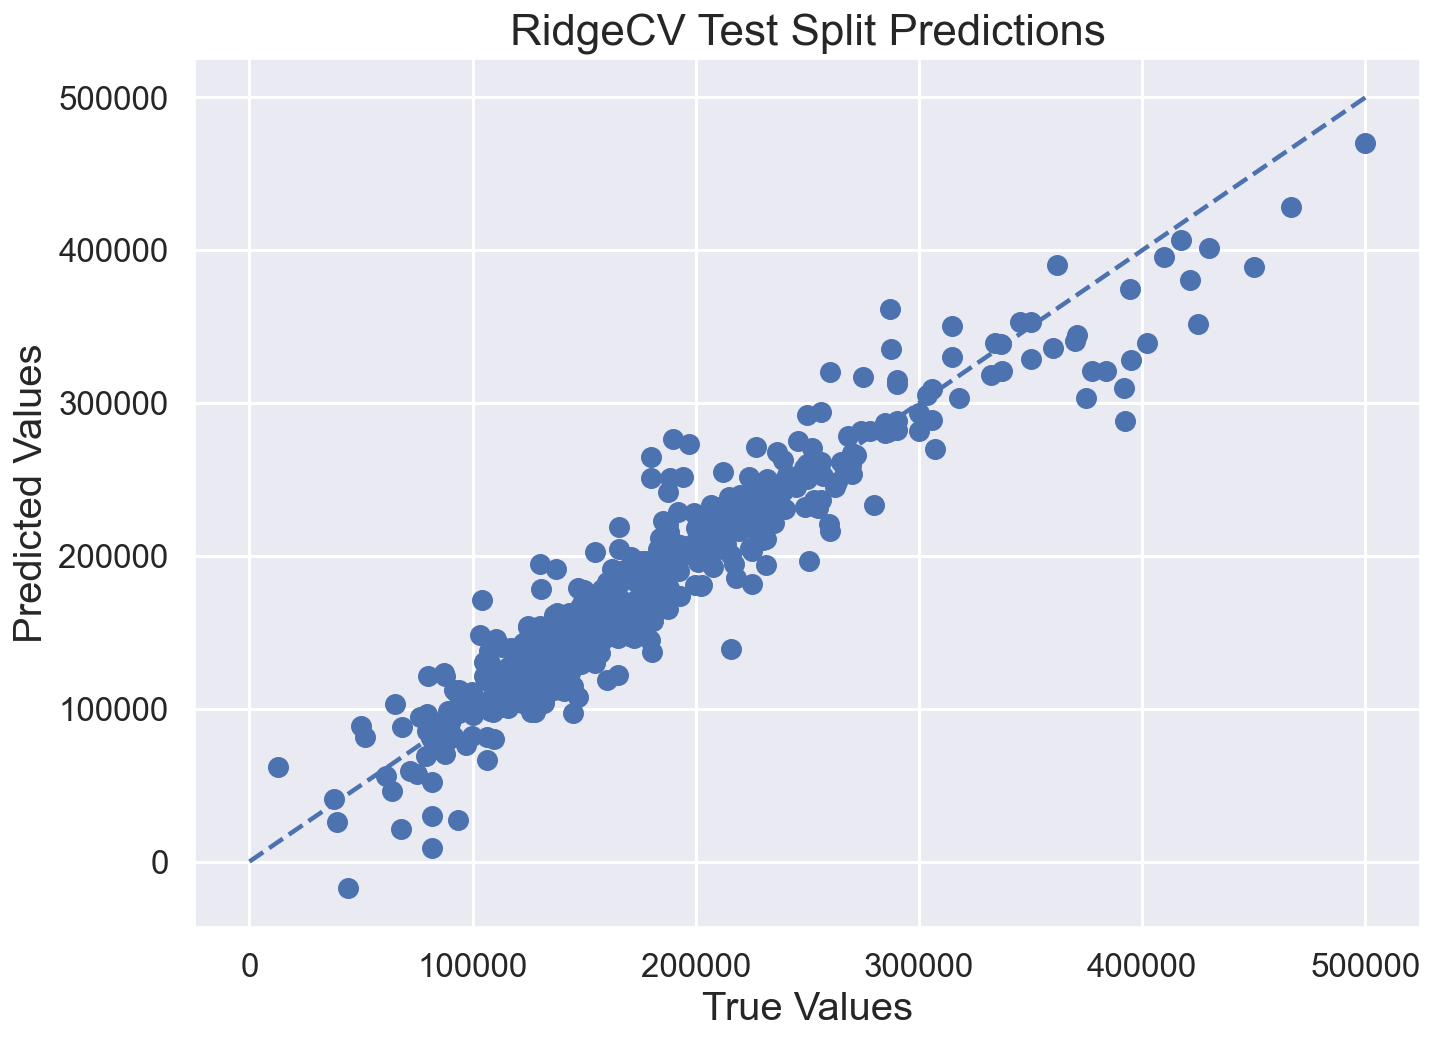

In [45]:
# Get predictions for the test split
y_preds_test = ridge.predict(X_test)

plt.figure(figsize = (11, 8))
plt.scatter(y_test, y_preds_test)

# Line showing perfect predictions.
plt.plot([0, max(max(y_test),max(y_preds_test))],
         [0, max(max(y_test),max(y_preds_test))],
         linestyle = '--')

plt.title('RidgeCV Test Split Predictions', fontsize = 22)
plt.xlabel('True Values', fontsize = 20)
plt.ylabel('Predicted Values', fontsize = 20);

Here, we can see that the model is able to predict the sale price accurately when the price of the house is about \\$350,000 and below. However, the model tends to under-predict the sale price when the true values are higher than that. This may be due to the non-fulfillment of some model assumptions as discussed above, or a lack of data in that price range for training the model (since the sale price has a positively skewed distribution).

## Checking RidgeCV coefficients 

The coeffients of the model can be visualised by plotting a bar chart:

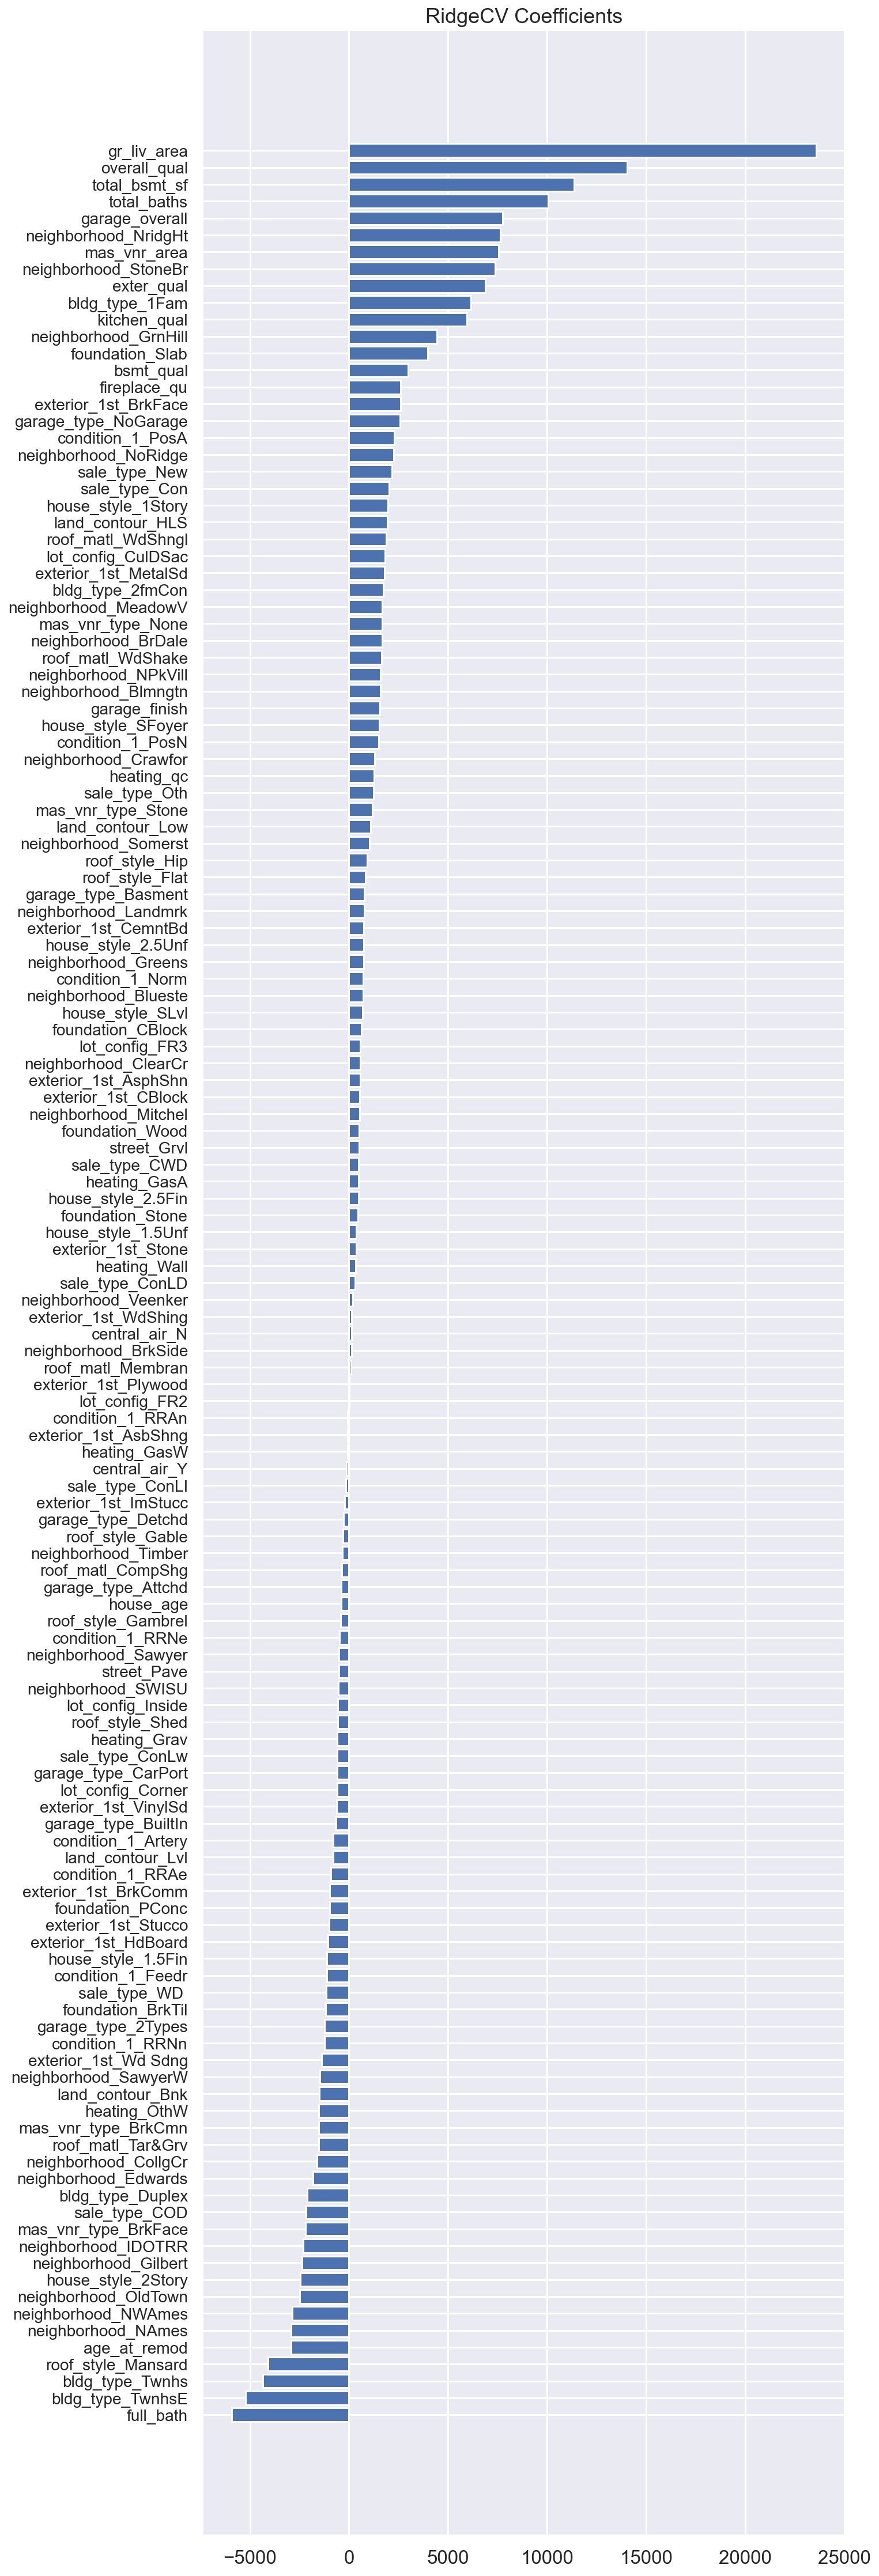

In [46]:
# Create a DataFrame to storing coefficients and corresponding variable names
coefficient_df = pd.DataFrame()

# Getting all the column names of predictors
coefficient_df['Column_Name'] = X_train_unscaled.columns

# Getting the coefficients of predictors
coefficient_df['Coefficient_Value'] = pd.Series(ridge.coef_)

# Sorting the DataFrame
coefficient_df = coefficient_df.sort_values(by='Coefficient_Value')

# Ploting the coefficent values
plt.figure(figsize=(10,40))
plt.barh(coefficient_df["Column_Name"], coefficient_df['Coefficient_Value'])
plt.title('RidgeCV Coefficients')
plt.tick_params(axis="y", labelsize=14);

The size of the living area, the overall quality and the total number of baths in the property are strongly positively correlated to the sale price. The overall garage score and the house being located in the Northridge Heights neighbourhood or the Stone Brook neighbourhood are also strongly positively correlated to the sale price, albeit not as much as the aforementioned features. 

On the other hand, the number of full baths is negatively correlated to the sale price. Perhaps a greater number of full baths in the property might be an undesirable feature due to the space or water consumption required. The property being a Townhouse End Unit or a Townhouse Inside Unit is also negatively correlated with the sale price. Townhouses may be priced cheaper or more unpopular than other types of dwellings that are more standalone.

# Conclusion and Recommendations

The data cleaning and feature engineering process led to a functional model with an R-squared score higher than 0.8, thus surpassing the initial objective set in the problem statement. This model was able to generalise well to new data and was not overfit to the training data. The Ridge Regression Cross-Validated R-Squared value was 0.907, which meant that the model was able to  explain 90% of the variability in sale price with the given set of input features. As compared to just guessing the mean sale price, the use of the model reduced that error by \\$49,846 and led to a final RMSE of \\$24,660. This provides a good foundation for buyers to know if they are overpaying for their house, or if sellers are underpricing their house. Such a predictive service would be especially useful for real estate agents, who have to maintain the balancing act between these two groups, and who require as much information as they can get in order to have an advantage in their job. Thus, the primary audience of real estate agents would be likely to benefit from this model.

The coefficient values of the model provide valuable information as well. Several important features affecting the sale price have been identified in this study, such as the size of the living area and the neighbourhood of the house. Such information could aid house-owners or developers of houses in knowing what features to construct in a house, so as to fetch a higher sale price. The information could even guide the decision-making regarding where to build a house, and what type of house to build. Thus, other than the ability to predict the price alone, the new visibility on these notable features is also useful and value-adding to people dealing with real estate. 

Further directions in this project could involve expanding the scope of the data analysed to other towns or cities, and also to test out models other than linear regression for the prediction. Also, the temporal aspect of the data could be studied to see if there are any changes or trends year by year. If there are anomalous years or time periods in the data, the model's generalisation ability would have been affected. On the flip side, if the differing patterns in time periods are identified (weather seasons, world events), the model's predictive abilities for market conditions characteristic of a particular time period could be enhanced by focussing on that scope. 

The preparation of the model and data for the Kaggle competition is conducted in the next notebook.

--End of Notebook--